In [1]:
import os,time,sys,datetime,math
import numpy as np
import pandas as pd

root = '/Users/Data/UCI/Confemm/CAHousing/'
filename = 'housing.csv'

path = os.path.join(root, filename)
df = pd.read_csv(path)
N_d = df.shape[0]
print(N_d)

print(df.columns)
print(df.isna().sum())
print(df.head())
df = df.dropna()

20640
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value

In [2]:
from sklearn.model_selection import train_test_split

Train = df.sample(frac=0.9)
Test = df.drop(Train.index)

# X = df.values[:,:-1].astype(np.float32)
# print(X.shape)
# y = df.values[:,-1].astype(np.int64)
# print(y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)
X_train = Train.values[:,:-2].astype(np.float32)
X_test = Test.values[:,:-2].astype(np.float32)
Y_train = Train.values[:,-2].astype(np.int64)
Y_test = Test.values[:,-2].astype(np.int64)

print(X_train.shape)
print(Y_test.shape)

(18390, 8)
(2043,)


In [6]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

cls = GradientBoostingRegressor(random_state=0)
cls.fit(X_train, Y_train)
score = cls.score(X_test, Y_test)
print(score)

0.7820454883272808


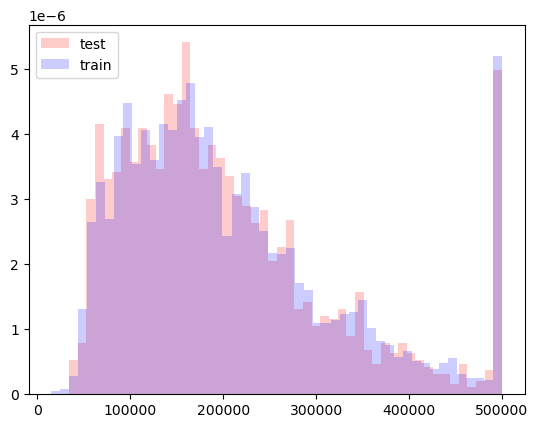

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(Y_test, bins=50, density=True, color='r', alpha=0.2, label='test')
ax.hist(Y_train, bins=50, density=True, color='b', alpha=0.2, label='train')
ax.legend()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Regressor(nn.Module):
    def __init__(self, infea:int=8, hidden:int=50, out:int=2, *args, **kwargs):
        super(Regressor, self).__init__(*args, **kwargs)
        self.infea = infea
        self.hidden = hidden
        self.out = out
        self.encoder = nn.Sequential(
            nn.Linear(infea, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
        )
        self.final = nn.Linear(hidden*4, out)

    def forward(self, x: Tensor):
        h = self.encoder(x)
        logits = self.final(h)
        return logits

In [5]:
def huber(x, k=0.1):
    return torch.where(x.abs() < k, 0.5*x.pow(2), k * (x.abs() - 0.5*k))

def quantile_huber_loss(y_true: np.ndarray, y_pred: torch.Tensor, quantiles: np.ndarray) -> torch.Tensor:
    u = y_true - y_pred
    s = quantiles - (u < torch.Tensor([0])).float()
    return torch.mean(s.abs() * huber(u))

In [6]:
import torch
import torch.nn as nn

class MultiQuantileLoss(nn.Module):
    def __init__(self, quantiles):
        """
        Initializes the loss function for multiple quantiles.
        Args:
            quantiles (list of float): List of quantiles, e.g., [0.1, 0.9]
        """
        super(MultiQuantileLoss, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_pred, y_true):
        """
        Computes the loss for each quantile and sums them.
        Args:
            y_pred (Tensor): Predicted outputs of shape (batch_size, num_quantiles)
            y_true (Tensor): Ground truth values of shape (batch_size, 1)
        Returns:
            Tensor: Combined loss for all quantiles
        """
        assert y_pred.shape[1] == len(self.quantiles), "Number of outputs must match number of quantiles"
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = y_true - y_pred[:, i:i+1]
            loss = torch.maximum((q - 1) * errors, q * errors)
            losses.append(torch.mean(loss))
        return sum(losses) / len(losses)


In [7]:
import copy
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from typing import Any, Optional, OrderedDict, List
from collections import defaultdict

def train(dataset: Optional[dict], model: nn.Module, optimizer: Optional[Any], scheduler: Optional[Any],
          epoch: int=100, batch_size: int=128, device: str='cpu'):
    trainloss = defaultdict(list)
    testloss = defaultdict(list)
    quantiles = [0.1, 0.9]
    # loss_fn = MultiQuantileLoss(quantiles)

    X_train, X_test, y_train, y_test = dataset['train_x'], dataset['test_x'], dataset['train_y'], dataset['test_y']
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epoch):
        print("epoch: " + str(epoch) + '===================================================')
        n_train = X_train.shape[0]
        n_test = X_test.shape[0]
        if epoch == 0:
            print(f'train length: {n_train}, test length: {n_test}')

        I = list(range(0, n_train))
        
        running_loss = 0.0
        running_test_loss = 0.0

        model.train()
        for i_batch in range(n_train // batch_size):
            if i_batch < (n_train // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_train[I_b, :]
            y_batch = y_train[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)
            y_batch = y_batch.unsqueeze(-1)
            # print(y_batch)

            with torch.set_grad_enabled(True):
                logits = model(x_batch)
                # loss = torch.nn.functional.cross_entropy(logits, y_batch)
                # loss = loss_fn(logits, y_batch)
                loss = quantile_huber_loss(y_batch, logits, torch.tensor(quantiles))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                trainloss['loss'].append(loss.item())
                running_loss += loss.item() * x_batch.size(0)

            if i_batch > 0 and i_batch % 50 == 0:
                print(f'ibatch: {i_batch}, train loss: {loss}.')
        
        epoch_loss = running_loss / n_train
        
        trainloss['epoch'].append(epoch_loss)

        I = list(range(0, n_test))
        model.eval()
        for i_batch in range(n_test // batch_size):
            if i_batch < (n_test // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_test[I_b, :]
            y_batch = y_test[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)
            y_batch = y_batch.unsqueeze(-1)

            with torch.set_grad_enabled(False):
                logits = model(x_batch)
                # loss = torch.nn.functional.cross_entropy(logits, y_batch)
                # loss = loss_fn(logits, y_batch)
                loss = quantile_huber_loss(y_batch, logits, torch.tensor(quantiles))

                testloss['loss'].append(loss.item())
                running_test_loss += loss.item()*x_batch.size(0)
                
        epoch_test_loss = running_test_loss / n_test
                
        testloss['epoch'].append(epoch_test_loss)

        print(f'test loss: {epoch_test_loss}.')

    time_elapsed = time.time() - since
    print(("Training complete in %sm %ss" % (time_elapsed // 60, time_elapsed % 60)))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    #         'scheduler_state_dict': scheduler.state_dict(),
        'trainloss': trainloss,
        'testloss': testloss,
        }, 'model_final')
    return model, trainloss, testloss

In [8]:
device = 'cpu'

datasets = dict()
datasets['train_x'] = X_train
datasets['test_x'] = X_test
datasets['train_y'] = Y_train
datasets['test_y'] = Y_test

model = Regressor().to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

model, trainloss, valloss = train(dataset=datasets, model=model, optimizer=optimizer, 
                                  scheduler=scheduler, epoch=50, batch_size=128)

epoch: 0===================================================
train length: 18390, test length: 2043
ibatch: 50, train loss: 10437.89453125.
ibatch: 100, train loss: 10751.392578125.
test loss: 10064.866100518539.
epoch: 1===================================================
ibatch: 50, train loss: 10339.3427734375.
ibatch: 100, train loss: 10605.3818359375.
test loss: 9878.617901160213.
epoch: 2===================================================
ibatch: 50, train loss: 10104.873046875.
ibatch: 100, train loss: 10324.056640625.
test loss: 9639.116505866066.
epoch: 3===================================================
ibatch: 50, train loss: 9740.39453125.
ibatch: 100, train loss: 9923.732421875.
test loss: 9079.811900582783.
epoch: 4===================================================
ibatch: 50, train loss: 9253.896484375.
ibatch: 100, train loss: 9391.65625.
test loss: 8558.454054718093.
epoch: 5===================================================
ibatch: 50, train loss: 8662.6962890625.
ib

2043


(array([  2.,   2.,   1.,   3.,  10.,  35.,  51.,  81., 153., 227., 229.,
        223., 175., 138.,  95.,  90.,  74.,  76.,  65.,  45.,  40.,  24.,
         32.,  21.,  20.,  17.,  12.,  15.,  12.,  14.,   8.,   8.,   3.,
          4.,   6.,   5.,   3.,   6.,   1.,   4.,   0.,   1.,   2.,   2.,
          1.,   5.,   1.,   0.,   0.,   1.]),
 array([-116917.375     , -107667.6640625 ,  -98417.9609375 ,
         -89168.25      ,  -79918.5390625 ,  -70668.828125  ,
         -61419.12109375,  -52169.4140625 ,  -42919.703125  ,
         -33669.99609375,  -24420.28710938,  -15170.57910156,
          -5920.87011719,    3328.83886719,   12578.54785156,
          21828.25585938,   31077.96484375,   40327.671875  ,
          49577.3828125 ,   58827.08984375,   68076.796875  ,
          77326.5078125 ,   86576.21875   ,   95825.9296875 ,
         105075.6328125 ,  114325.34375   ,  123575.0546875 ,
         132824.765625  ,  142074.46875   ,  151324.171875  ,
         160573.890625  ,  169823.5937

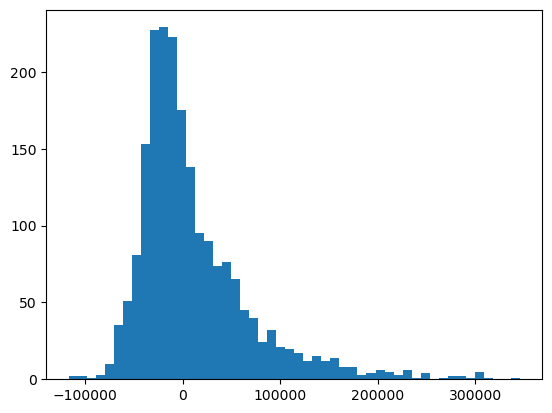

In [9]:
x_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test = torch.from_numpy(Y_test).to(torch.int64).to(device)

scores = torch.maximum(model(x_test)[:,0]-y_test, y_test-model(x_test)[:,1])
print(len(scores))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(scores.detach().cpu().numpy(), density=False, bins=50)

In [10]:
alpha = 0.1
n = len(scores)
# print(scores)
qhat = torch.quantile(scores, np.ceil((n+1)*(1-alpha))/n)
print(qhat)

tensor(86969.2266, grad_fn=<SqueezeBackward4>)


2043
avg cov: 0.894090
avg cov: 0.899630


/var/folders/7f/h_yx8r3d3rb_y8lsptbgys440000gn/T/ipykernel_21488/684108181.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_ = torch.tensor(scores)


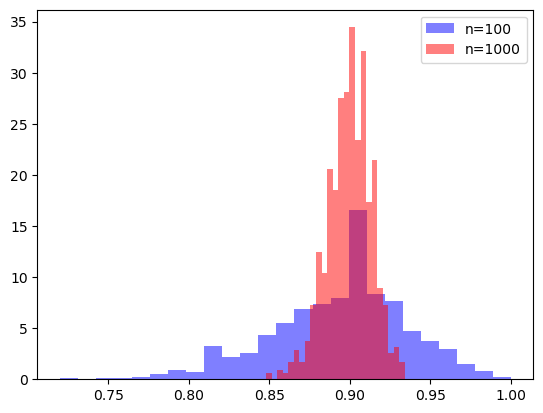

In [11]:
R = 1000
print(n)
alpha=0.1
scores_ = torch.tensor(scores)
coverages = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(2043)]
    calib_scores, val_scores = (scores__[:100], scores__[1943:])
    qhat_ = torch.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n)
    coverages[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages.mean()
print('avg cov: %f' % average_coverage)

coverages2 = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(2043)]
    calib_scores, val_scores = (scores__[:1000], scores__[1024:])
    # print(calib_scores.mean())
    qalpha = np.ceil((n+1)*(1-alpha))/n
    # print(qalpha)
    qhat_ = torch.quantile(calib_scores, qalpha)
    # print(qhat_)
    coverages2[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages2.mean()
print('avg cov: %f' % average_coverage)
plt.hist(coverages,bins=25,density=True,label='n=100', color='blue', alpha=0.5)
plt.hist(coverages2,bins=25,density=True,label='n=1000', color='red', alpha=0.5)
plt.legend()

torch.Size([18390])
18390


(array([7.300e+01, 1.990e+02, 2.040e+02, 2.260e+02, 4.330e+02, 7.180e+02,
        1.007e+03, 1.100e+03, 1.116e+03, 1.176e+03, 1.139e+03, 1.187e+03,
        1.219e+03, 1.094e+03, 1.094e+03, 9.440e+02, 7.880e+02, 6.610e+02,
        5.950e+02, 5.260e+02, 4.530e+02, 3.610e+02, 2.830e+02, 2.120e+02,
        2.020e+02, 1.550e+02, 1.220e+02, 1.310e+02, 1.110e+02, 8.800e+01,
        1.180e+02, 2.590e+02, 2.340e+02, 6.500e+01, 4.500e+01, 2.400e+01,
        1.300e+01, 1.100e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([193783.3125 , 200084.88125, 206386.45   , 212688.01875,
        218989.5875 , 225291.15625, 231592.725  , 237894.29375,
        244195.8625 , 250497.43125, 256799.     , 263100.56875,
        269402.1375 , 275703.70625, 282005.275  , 288306.84375,
        294608.4125 , 300909.98125, 307211.55   , 313513.11875,
        319814.6875 , 326116.25625, 332417.825  , 338719

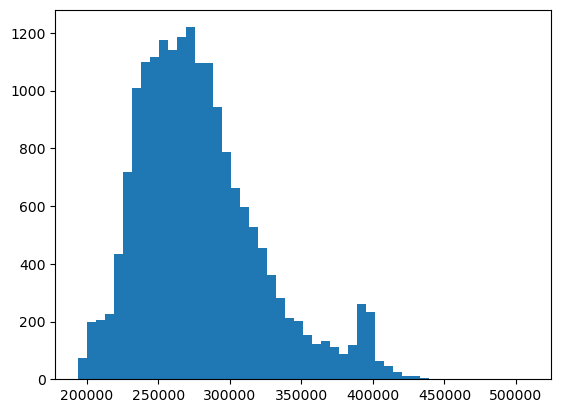

In [12]:
x_train = torch.from_numpy(X_train).to(torch.float32).to(device)

prediction_sets = (model(x_train)[:,0]-qhat, model(x_train)[:,1]+qhat)
print(prediction_sets[0].size())
sets = []
for i in range(x_train.shape[0]):
    sets.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
print(len(sets))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(sets, density=False, bins=50)

In [13]:
import os
import sys
sys.path.append(os.getcwd())
import pandas as pd
import numpy as np
from numpy import linalg as LA
import heapq

key_labels = {}
#
def as_string(desc):
    return ' and '.join(desc)

def satisfies_all(desc,df,N):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    cover_desc = sum(ind)
    return (cover_desc / N > 0.001 and cover_desc / N < 0.5)

class BoundedPriorityQueue:
    """
    Ensures uniqness
    Keeps a maximum size (throws away value with least quality)
    """

    def __init__(self, bound, df):
        self.values = []
        self.bound = bound
        self.entry_count = 0
        self.df = df

    def desc_intersect(self, desc1, coverage, desc2, c):
        ind_new = self.df.eval(as_string(desc1))
        ind_old = self.df.eval(as_string(desc2))
        if coverage*0.9 > c:
            return False
        if (ind_new & ind_old).sum() > c*0.8:
            return True
        return False

    def add(self, element, quality, coverage):
        if any((e == element for (_, _, e, _) in self.values)):
            return  # avoid duplicates

        # if any((self.desc_intersect(element, coverage, e, c) for (_,_,e,c) in self.values)):
        #     return        

        new_entry = (quality, self.entry_count, element, coverage)
        if (len(self.values) >= self.bound):
            temp=heapq.heappushpop(self.values, new_entry)
        else:
            heapq.heappush(self.values, new_entry)

        self.entry_count += 1

    def get_values(self):
        for (q, _, e, coverage) in sorted(self.values, reverse=True):
            yield (e, q, coverage)

    def out_vectors(self):
        return [q for (q, _, _, _) in sorted(self.values, reverse=True)]

    def show_contents(self):  # for debugging
        print("show_contents")
        for (q, entry_count, e, coverage) in self.values:
            # print(q, entry_count, e)
            print("quality: %f, entry: %d, element: %s, coverage: %f" % (q, entry_count, e, coverage))

#
class Queue:
    """
    Ensures uniqness
    """

    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def enqueue(self, item):
        if item not in self.items:
            self.items.insert(0, item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

    def get_values(self):
        return self.items

    def add_all(self, iterable):
        for item in iterable:
            self.enqueue(item)

    def clear(self):
        self.items.clear()

In [18]:
def refine(desc, more):
    copy = desc[:]
    copy.append(more)
    return copy

def eta(seed,fs,df):
    for f in fs:
        column_data = df[f]
        if (df[f].dtype == 'float32'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'object'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'int64'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'bool'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)                    
        else:
            assert False

def varphi_ent(d,n):
    return np.sqrt(-(d/n)*np.log2(d/n) - ((n-d)/n)*np.log2((n-d)/n))

def eval_quality(desc, model, df, mu_omega):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    df_sd = df.loc[ind]

    x_sd = df_sd.values[:, :-1].astype(np.float32)
    x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)

    prediction_sets = (model(x_sd)[:,0]-qhat, model(x_sd)[:,1]+qhat)
    sets_sd = []
    for i in range(x_sd.shape[0]):
        sets_sd.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
    mu_sd = np.mean(sets_sd)
    quality = mu_omega - mu_sd
    # quality = mu_sd - mu_omega

    coverage = sum(ind) / df.shape[0]
    # ent = varphi_ent(sum(ind), df.shape[0])
    return quality, coverage

def EMM(df, fs, model, w, d, q, eta, satisfies_all, eval_quality):
    """
    w - width of beam
    d - num levels
    q - max results
    eta - a function that receives a description and returns all possible refinements
    satisfies_all - a function that receives a description and verifies wheather it satisfies some requirements as needed
    eval_quality - returns a quality for a given description. This should be comparable to qualities of other descriptions
    catch_all_description - the equivalent of True, or all, as that the whole dataset shall match
    """
    N = df.shape[0]

    x_omega = df.values[:, :-1].astype(np.float32)
    x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)

    prediction_sets = (model(x_omega)[:,0]-qhat, model(x_omega)[:,1]+qhat)
    sets_omega = []
    for i in range(x_omega.shape[0]):
        sets_omega.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
    mu_omega = np.mean(sets_omega)
    print('mu omega: %f' % mu_omega)
                
    resultSet = BoundedPriorityQueue(q,df)
    candidateQueue = Queue()
    candidateQueue.enqueue([])
    for level in range(d):
        print("level : %d" % level)
        beam = BoundedPriorityQueue(w,df)
        for seed in candidateQueue.get_values():
            print("seed : %s" % str(seed))
            for desc in eta(seed, fs, df):
                if satisfies_all(desc,df,N):
                    quality, coverage = eval_quality(desc, model, df, mu_omega)
                    resultSet.add(desc, quality, coverage)
                    beam.add(desc, quality, coverage)
        beam.show_contents()
        #candidateQueue.clear()
        candidateQueue = Queue()
        candidateQueue.add_all(desc for (desc, _, _) in beam.get_values())
    return resultSet


In [19]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

print("features: %s" % features)

dff = Train[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income','median_house_value']]
dff = dff.astype(np.float32)

EMM_res = EMM(df=dff, fs=features, model=model, w=20, d=2, q=10, eta=eta, satisfies_all=satisfies_all, eval_quality=eval_quality)

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc,quality,coverage))

features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
mu omega: 279400.923890
level : 0
seed : []
show_contents
quality: 18707.555028, entry: 40, element: ['households > 3379.333'], coverage: 0.001523
quality: 22438.183770, entry: 33, element: ['total_bedrooms > 3581.000'], coverage: 0.001849
quality: 24384.371896, entry: 37, element: ['households > 1352.333'], coverage: 0.032572
quality: 22583.144038, entry: 25, element: ['total_rooms > 8432.000'], coverage: 0.022784
quality: 22894.392192, entry: 30, element: ['total_bedrooms > 1433.000'], coverage: 0.036052
quality: 29168.435348, entry: 27, element: ['total_rooms > 16862.000'], coverage: 0.003263
quality: 27782.342886, entry: 13, element: ['latitude > 38.813'], coverage: 0.055411
quality: 36458.417538, entry: 41, element: ['median_income <= 2.111'], coverage: 0.140348
quality: 24575.733748, entry: 0, element: ['longitude <= -123.234'], coverage: 0.00940

mu omega: 279400.923890
['population > 3967.333', 'households <= 1352.333'];51232.92654060639;0.00609026644915715

112
['population > 3967.333', 'total_rooms <= 8432.000'];51137.378846575506;0.011364872213159325

209
['longitude > -115.426', 'median_income <= 2.111'];49965.76053766403;0.0011963023382272975

22
['median_income <= 2.111', 'longitude > -115.426'];49965.76053766403;0.0011963023382272975

22
['population > 3967.333', 'median_income <= 3.722'];48727.973698610236;0.013322457857531268

245
6832


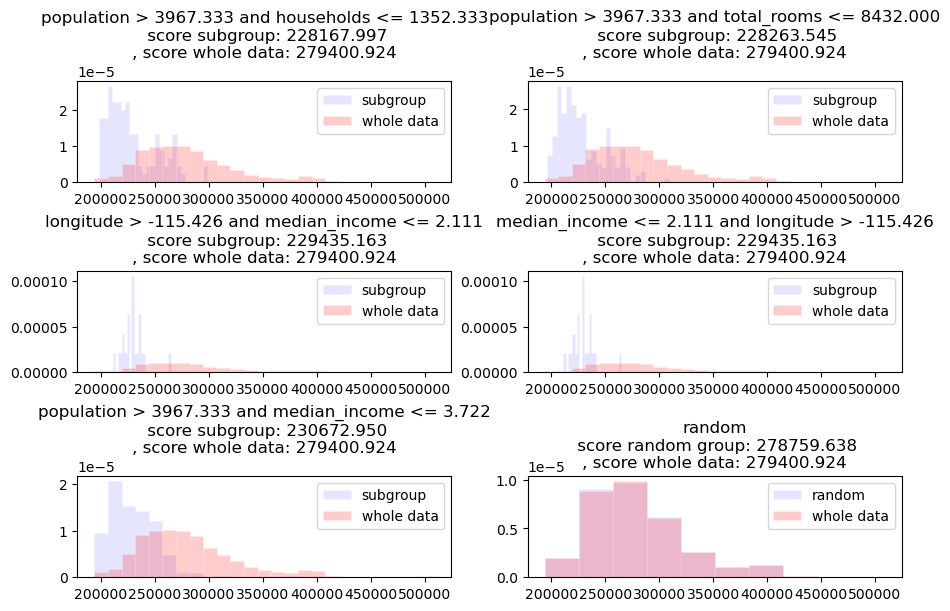

In [20]:
N_dff = dff.shape[0]

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)

prediction_sets = (model(x_omega)[:,0]-qhat, model(x_omega)[:,1]+qhat)
sets_omega = []
for i in range(x_omega.shape[0]):
	sets_omega.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
mu_omega = np.mean(sets_omega)
print('mu omega: %f' % mu_omega)

k = 0
q = 5
fig, axs = plt.subplots(3, 2, figsize=(9, 6), layout='constrained')

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc, quality, coverage))
	d_str = as_string(desc)
	ind = dff.eval(d_str)
	df_sd = dff.loc[ind]

	x_sd = df_sd.values[:, :-1].astype(np.float32)
	x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)

	prediction_sets = (model(x_sd)[:,0]-qhat, model(x_sd)[:,1]+qhat)
	sets_sd = []
	for i in range(x_sd.shape[0]):
		sets_sd.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
	mu_sd = np.mean(sets_sd)
	print(len(sets_sd))
	quality = mu_omega - mu_sd

	ax = axs.flat[k]
	if ax is None:
		ax = plt.gca()

	preds_sd = sets_sd
	preds_wd = sets_omega
	ax.hist(preds_sd, linewidth=0.5, bins=25, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
	ax.hist(preds_wd, linewidth=0.5, bins=25, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
	score_sd = np.mean(sets_sd)
	score_all = np.mean(sets_omega)
	ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}\n, score whole data: {(score_all):<0.3f}')
	ax.legend()
	k += 1
	if k == 5:
		break

inds_rand = np.random.permutation(N_dff)
flag = np.random.randint(np.int32(0.2*N_dff), np.int32(0.5*N_dff))
inds_rand = inds_rand[:flag]
inputs = dff.iloc[inds_rand]

x_rand = inputs.values[:, :-1].astype(np.float32)
x_rand = torch.from_numpy(x_rand).to(torch.float32).to(device)
prediction_sets = (model(x_rand)[:,0]-qhat, model(x_rand)[:,1]+qhat)
sets_rand = []
for i in range(x_rand.shape[0]):
	sets_rand.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
mu_sd = np.mean(sets_rand)
print(len(sets_rand))

ax = axs.flat[k]
preds_sd = sets_rand
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='random', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
score_sd = np.mean(sets_rand)
score_all = np.mean(sets_omega)
ax.set_title(f'{'random'}\n score random group: {(score_sd):<0.3f}\n, score whole data: {(score_all):<0.3f}')
ax.legend()